In [1]:
import numpy as np
from cmeutils.sampling import is_equilibrated, equil_sample
from cmeutils.structure import (
    gsd_rdf,
    structure_factor,
    diffraction_pattern,
    get_quaternions,
#    #nematic_order_parameter
)
#from cmeutils.polymers import get_bond_vectors

import unyt as u
from unyt import Unit
import signac
import gsd.hoomd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import freud
import rowan

import os
import grits
import mbuild as mb
import ele
import matplotlib
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

conv_dict = {
    "ca": ele.element_from_symbol("C"),
    "s": ele.element_from_symbol("S"),
    "sh": ele.element_from_symbol("S"),
}

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.

****** PyMBAR will use 64-bit JAX! *******
* JAX is currently set to 32-bit bitsize *
* which is its default.                  *
*                                        *
* PyMBAR requires 64-bit mode and WILL   *
* enable JAX's 64-bit mode when called.  *
*                                        *
* This MAY cause problems with other     *
* Uses of JAX in the same code.          *
******************************************

/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from 

In [2]:
# Matplotlib RC Params:    
color_dict = {1.0: "#0F0E0F", 0.8: "#666666", 0.7: "#964d4d", 0.6: "#d03f3f"}
symbol_dict = {1.0: "o", 0.8: "s", 0.7: "^", 0.6: "d"}
plt.rcParams["figure.figsize"] = (3, 3)
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["legend.fontsize"] = 7
plt.rcParams['lines.markersize'] = 3
plt.rcParams["lines.linestyle"] = "-"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["legend.markerscale"] = 1

colors = [
    "#FF5733",  # Vermilion
    "#FFC300",  # Saffron
    "#4B0082",  # Indigo
    "#00A86B",  # Jade
    "#007FFF",  # Azure
    "#D2691E",  # Chocolate
    "#FF4500",  # Orange Red
    "#6A0DAD",  # Purple
    "#2E8B57",  # Sea Green
    "#FF6EC7",  # Blush Pink
    "#800080",  # Purple
    "#4682B4",  # Steel Blue
    "#008B8B",  # Dark Cyan
    "#E9967A",  # Dark Salmon
    "#FFD700",  # Gold
    "#800000",  # Maroon 
]

def get_bond_vectors(snapshot, bond_type_filter=None):
    """Get all normalized bond vectors of a certain bond type.

    Parameters
    ---------
    snapshot : gsd.hoomd.Frame, required
        Frame of the GSD trajectory file to use
    bond_types : list-like, required
        List of bond types to find bond vectors
        Choose from options found in gsd.hoomd.Frame.bonds.types

    Returns
    ------
    vectors : List of arrays (shape=(1,3)
        List of all normalized bond vectors matching bond_types

    """
    if not bond_type_filter:
        bond_type_filter = snapshot.bonds.types
    vectors = []
    for bond in bond_type_filter:
        if bond not in snapshot.bonds.types:
            raise ValueError(
                f"Bond type {bond} not found in snapshot.bonds.types"
            )
        bond_id = snapshot.bonds.types.index(bond)
        bond_indices = np.where(snapshot.bonds.typeid == bond_id)[0]
        for i in bond_indices:
            bond_group = snapshot.bonds.group[i]
            p1 = snapshot.particles.position[bond_group[0]]
            p2 = snapshot.particles.position[bond_group[1]]
            vectors.append((p2 - p1) / np.linalg.norm(p2 - p1))
    return vectors

def generate_color_gradient(start_color, end_color, num_steps):
    """Generate a gradient of colors between two given colors.

    Parameters:
    - start_color: Starting color in RGB format (e.g., [r, g, b])
    - end_color: Ending color in RGB format (e.g., [r, g, b])
    - num_steps: Number of steps in the gradient

    Returns:
    - colors: List of color codes representing the gradient
    """
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", [start_color, end_color])
    norm = mcolors.Normalize(vmin=0, vmax=num_steps-1)
    colors = [cmap(norm(i)) for i in range(num_steps)]
    return colors


def nematic_order_parameter(vectors, director):
    """Finds the nematic (S2) order parameter for a list of vectors
    Parameters
    ----------
    vectors : sequence of vectors; required
        The list of vectors to use in the nematic order parameter calculation
    director : numpy.ndarray, shape=(1,3)
        The nematic director of the reference state

    Returns
    -------
    freud.order.Nematic
    """
    vectors = np.asarray(vectors)
    orientations = rowan.normalize(
        np.append(np.zeros((vectors.shape[0], 1)), vectors, axis=1)
    )
    nematic = freud.order.Nematic(np.asarray(director))
    nematic.compute(orientations)
    return nematic
    

def kT_to_T(kT, epsilon):
    """kT converted to C"""
    return ((kT*epsilon)/8.31446262) - 273.15


def k_vector_to_2theta(k, wave_length):
    """"""
    d = 2*np.pi / k
    return 2 * np.arcsin(wave_length/(2*d))


def k_vector_to_distance(k):
    return (2 * np.pi) / k

SAVE_FIGS = True

In [3]:
project = signac.get_project("../validation")
#project = signac.get_project("../training-runs/low-density-states/")

In [4]:
def append_first_frame(job):
    fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")

    with gsd.hoomd.open(job.fn("combined-nvt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

def append_first_frame_npt(job):
    #if job.doc.npt_runs < 2:
    run = int(job.doc.npt_runs - 1)
    #else:
    #    run = int(job.doc.npt_runs - 2)
    print(run)
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    print(fpath)
    with gsd.hoomd.open(job.fn("combined-npt.gsd"), "w") as new_traj:
        with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
            new_traj.append(init_traj[0])
        with gsd.hoomd.open(fpath) as nvt_traj:
            for frame in nvt_traj:
                new_traj.append(frame)

# Corase-grain the trajectories:

In [ ]:
def coarse_grain_last_npt(job):
    run = job.doc.npt_runs - 1
    fpath = job.fn(f"trajectory-npt{run}.gsd")
    with gsd.hoomd.open(job.fn("temp-npt.gsd"), "w") as temp_traj: # Delete this traj after CGing
        with gsd.hoomd.open(fpath, "r") as last_traj:
            with gsd.hoomd.open(job.fn("trajectory-npt0.gsd"), "r") as init_traj:
                temp_traj.append(init_traj[0])
                for frame in last_traj:
                    temp_traj.append(frame)

    bead_mapping = {"A": "c1ccc(S)cc1"}
    
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("temp-npt.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        length_scale=job.doc.ref_length,
        mass_scale=job.doc.ref_mass,
        conversion_dict=conv_dict
    )
    
    cg_system.save(job.fn("last-npt-cg.gsd"), add_images=False, stride=50)
    os.remove(job.fn("temp-npt.gsd"))

In [ ]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    #job.doc.avg_density = den_dict[job.sp.kT]
    #job.doc.skip_npt_equil = True

In [ ]:
for job in project.find_jobs({"doc.npt_equilibrated": False, "sigma_scale": 0.955}):
    print(job.sp.kT, job.sp.sigma_scale, job.path)
    coarse_grain_last_npt(job)

In [ ]:
test_job = project.open_job(id="e6e236135ac867add24f9d4d31ee2741")

In [ ]:
bead_mapping = {"A": "c1ccc(S)cc1"}
for job in project:
    cg_system = grits.coarsegrain.CG_System(
        gsdfile=job.fn("trajectory.gsd"),
        beads=bead_mapping,
        add_hydrogens=job.sp.remove_hydrogens,
        length_scale=job.doc.ref_length,
        mass_scale=job.doc.ref_mass,
        conversion_dict=conv_dict
    )
    cg_system.save(job.fn("target-1monomer-per-bead.gsd"))

In [ ]:
grits.__path__

In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True}).groupby("kT"):
    for job in jobs:
        if job.isfile("cg-nvt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-nvt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-nvt.gsd"))
        print()

In [ ]:
for kT, jobs in project.find_jobs().groupby("kT"):
    for job in jobs:
        if job.isfile("cg-npt.gsd"):
            continue
        print(job.id)
        append_first_frame(job)
        fpath = job.fn("combined-npt.gsd")
        bead_mapping = {"A": "c1ccc(S)cc1"}
        cg_system = grits.coarsegrain.CG_System(
            gsdfile=fpath,
            beads=bead_mapping,
            add_hydrogens=job.sp.remove_hydrogens,
            conversion_dict=conv_dict
        )
        cg_system.save(job.fn("cg-npt.gsd"))
        print()

# Order Parameters:

In [4]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "doc.npt_equilibrated": True,
    "doc.nvt_equilibrated": True,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    if job.sp.kT < 2.4: continue
    print(job.sp.kT, job.id)
    run = job.doc.npt_runs - 1
    nem_orders = []
    with gsd.hoomd.open(job.fn("target_1monomer_per_bead.gsd"), "r") as traj:
        for snap in traj[0:-1:10]:
            bond_vectors = get_bond_vectors(snap, bond_type_filter=["A-A"])
            _nem_orders = []
            for director in [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 1)]:
                nem = nematic_order_parameter(vectors=bond_vectors, director=director)
                _nem_orders.append(nem.order)
            nem_orders.append(np.max(_nem_orders))
    print(len(nem_orders))
    job.doc.avg_nem = np.mean(nem_orders)
    job.doc.nem_std = np.std(nem_orders)

2.6 a5250cea52a262d308592249ce463d10
52
2.8 51e475756aeadda668351a024760dcda


/home/chrisjones4/miniconda3/envs/pps-msibi/lib/python3.11/site-packages/synced_collections/numpy_utils.py:46: NumpyConversionWarning: Any numpy types provided will be transparently converted to the closest base Python equivalents.
  warnings.warn(NUMPY_CONVERSION_WARNING, NumpyConversionWarning)


52
3.2 d4f337da0a7ee79a1778c858471aa917
52
4.0 96282e58fc96112640e1330198828903
52
4.6 212e36add95bb5744b05aa8ce8d29449
52
3.1 100888a4bbe8114d13b7c682ba77a678
52
2.4 9142f5e776ff060fb7edb01495a9a86e
52
2.9 9a2350bfd349debae443b6dd5f1beb2f
52
2.5 1cbc57c38be8cfe0ae9994bcb19467e2
52
3.0 73e2a18dd6e440ba0066c934fcb829e0
52
4.4 28aa0133175e9cf18fd68e541cb012ee
52
3.6 ddff72030898e479189cd2df660938e3
52
3.8 887213b5081db9f0d4bb1b606c0206a4
52
3.4 39edcdb395b6b0d3c3028c6feb7547af
52
4.2 24e102558a3471c0accad805e64ff332
52


In [ ]:
kT_to_T(2.2887, epsilon=1065)

<>:28: DeprecationWarning: invalid escape sequence '\,'
<>:29: DeprecationWarning: invalid escape sequence '\,'
<>:31: DeprecationWarning: invalid escape sequence '\,'
<>:37: DeprecationWarning: invalid escape sequence '\c'
<>:28: DeprecationWarning: invalid escape sequence '\,'
<>:29: DeprecationWarning: invalid escape sequence '\,'
<>:31: DeprecationWarning: invalid escape sequence '\,'
<>:37: DeprecationWarning: invalid escape sequence '\c'
/tmp/ipykernel_128528/3855883569.py:28: DeprecationWarning: invalid escape sequence '\,'
  plt.vlines(x=(358.15-273.15), ymin=0.2, ymax=0.8, label="$Tg\,(85^\circ C)$", linestyle="--", color="r")
/tmp/ipykernel_128528/3855883569.py:29: DeprecationWarning: invalid escape sequence '\,'
  plt.vlines(x=(135), ymin=0.2, ymax=0.8, label="$Tc\,(110 - 135^\circ C)$", linestyle="--", color="orange")
/tmp/ipykernel_128528/3855883569.py:31: DeprecationWarning: invalid escape sequence '\,'
  plt.vlines(x=(553.15-273.15), ymin=0.2, ymax=0.65, label="$Tm\,(280

1.0 -145.05994190794738 0.3637938972240613
1.2 -119.44193028953686 0.37274471090899575
1.4 -93.82391867112634 0.4126583069562912
1.6 -68.20590705271582 0.3373882551620036
1.8 -42.58789543430527 0.3742440193891525
2.0 -16.969883815894775 0.33708341121673585
2.2 8.648127802515774 0.42287211418151854
2.4 34.266139420926265 0.3332409652379843
2.5 47.07514523013157 0.3084167969914583
2.6 59.884151039336814 0.355238265142991
2.7 72.69315684854206 0.3328443770855665
2.8 85.5021626577473 0.2736963861836837
2.9 98.31116846695261 0.47925202204630923
3.0 111.12017427615785 0.7262270129643954
3.1 123.9291800853631 0.667310682626871
3.2 136.73818589456835 0.39178206714300007
3.4 162.3561975129789 0.4233624694439081
3.6 187.97420913138944 0.34340993945415205
3.8 213.59222074979994 0.3290551327742063
4.0 239.21023236821043 0.3211296538893993
4.2 264.82824398662103 0.31757529423787045
4.4 290.4462556050315 0.31359007266851574
4.6 316.064267223442 0.3062274748316178


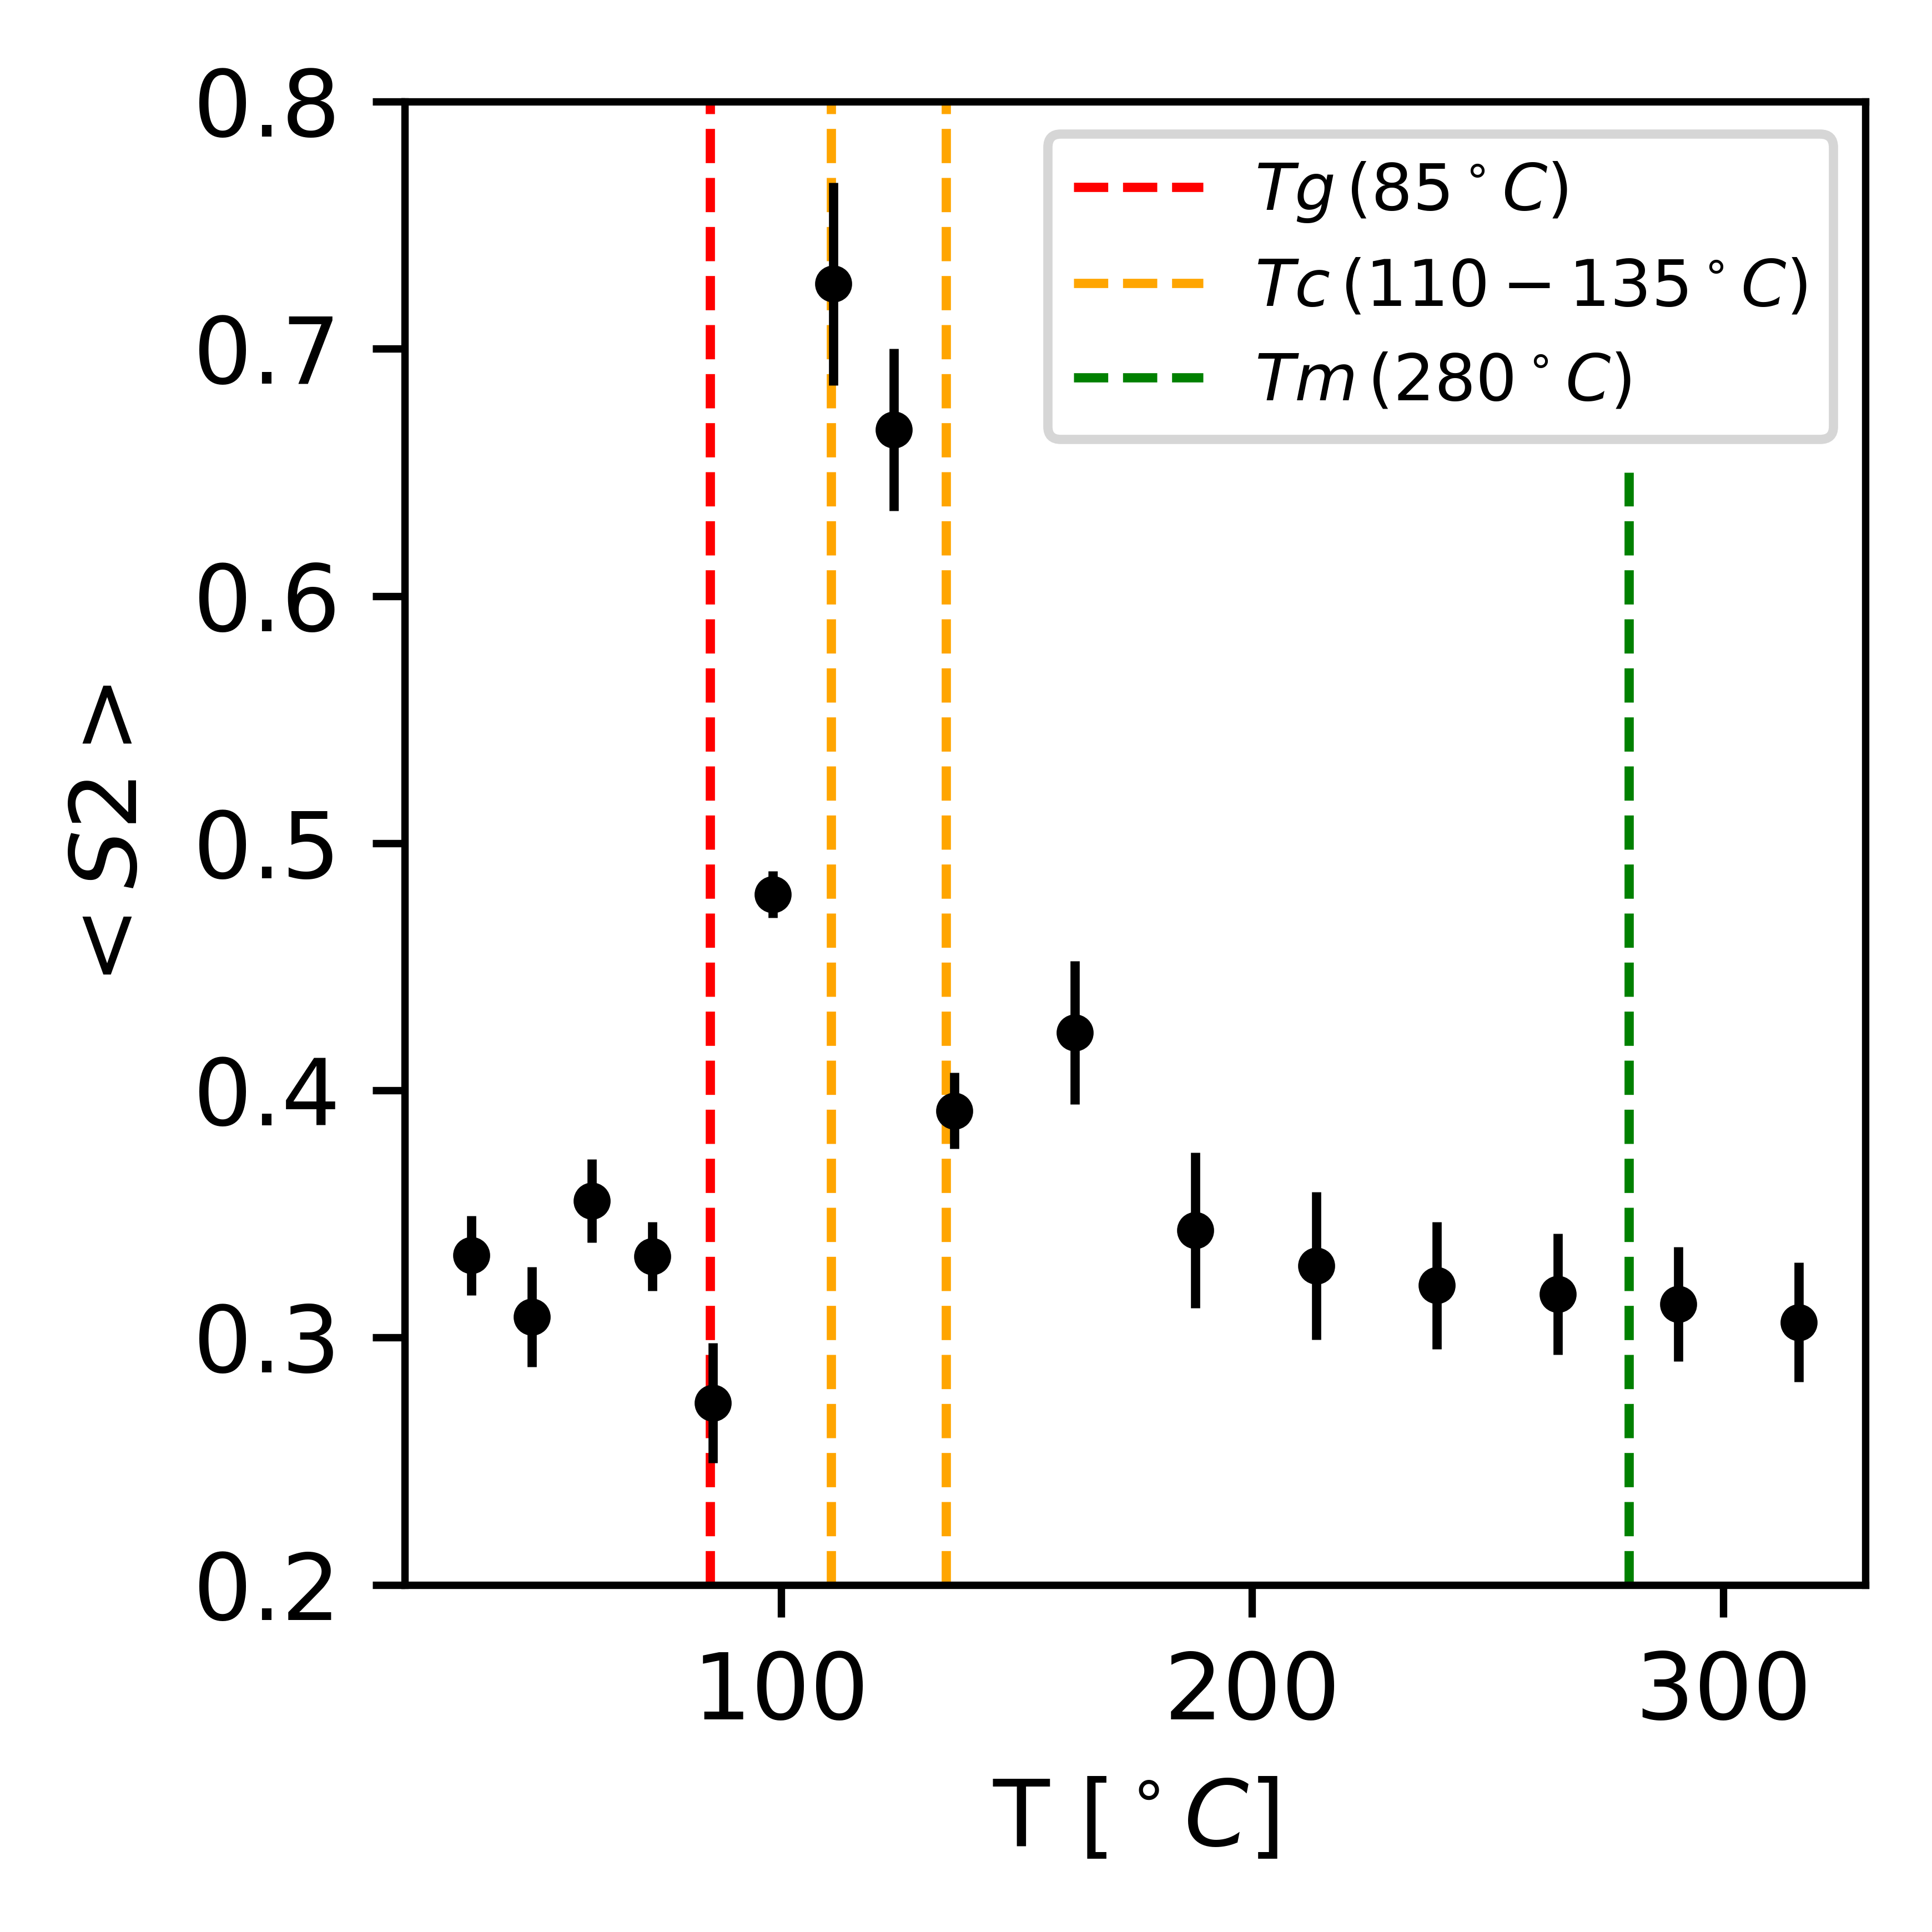

In [8]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
fig = plt.figure()
temps = []
reduced_temps = []
avg_nems = []
std_nems = []
for kT, job in project.find_jobs(filter=job_filter).groupby("kT"):
    job = list(job)[0]
    T = kT_to_T(job.sp.kT, epsilon=1065)
    print(kT, T, job.doc.avg_nem)
    if job.sp.kT < 2.4: continue
    try:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        temps.append(T)
        reduced_temps.append(kT)
        avg_nems.append(job.doc.avg_nem)
        std_nems.append(job.doc.nem_std)
        #plt.errorbar(x=T, y=job.doc.avg_nem, yerr=job.doc.nem_std, marker="o", color="k")
    except:
        pass
        
plt.vlines(x=(358.15-273.15), ymin=0.2, ymax=0.8, label="$Tg\,(85^\circ C)$", linestyle="--", color="r")
plt.vlines(x=(135), ymin=0.2, ymax=0.8, label="$Tc\,(110 - 135^\circ C)$", linestyle="--", color="orange")
plt.vlines(x=110.6, ymin=0.2, ymax=0.8, label=None, linestyle="--", color="orange")
plt.vlines(x=(553.15-273.15), ymin=0.2, ymax=0.65, label="$Tm\,(280^\circ C)$", linestyle="--", color="g")
plt.errorbar(x=temps, y=avg_nems, yerr=std_nems, marker="o", color="k", linestyle="")
#plt.errorbar(x=reduced_temps, y=avg_nems, yerr=std_nems, marker="o", color="k", linestyle="")

plt.ylim(0.2, 0.8)
plt.legend()
plt.xlabel("T [$^\circ C$]")
plt.ylabel("$<S2>$")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig("../FIGS/ua-S2-sweep-results.png")

In [6]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
fig = plt.figure()
temps = []
reduced_temps = []
avg_nems = []
std_nems = []
for kT, jobs in project.find_jobs(filter=job_filter).groupby("kT"):
    for job in jobs:
        T = kT_to_T(job.sp.kT, epsilon=1065)
        print(T, kT, job.doc.avg_nem, job.doc.avg_density)

-145.05994190794738 1.0 0.3637938972240613 1.395652110744935
-119.44193028953686 1.2 0.37274471090899575 1.3814714109288648
-93.82391867112634 1.4 0.4126583069562912 1.3956339524298362
-68.20590705271582 1.6 0.3373882551620036 1.383165254565274
-42.58789543430527 1.8 0.3742440193891525 1.3801096862121909
-16.969883815894775 2.0 0.33708341121673585 1.3686785297722928
8.648127802515774 2.2 0.42287211418151854 1.3557969861989738
34.266139420926265 2.4 0.3332409652379843 1.3392703348028023
47.07514523013157 2.5 0.3084167969914583 1.3231743070374549
59.884151039336814 2.6 0.355238265142991 1.3158424105494935
72.69315684854206 2.7 0.3328443770855665 1.29
85.5021626577473 2.8 0.2736963861836837 1.3663529132536296
98.31116846695261 2.9 0.47925202204630923 1.3473824504407481
111.12017427615785 3.0 0.7262270129643954 1.3655533350635436
123.9291800853631 3.1 0.667310682626871 1.397248220141228
136.73818589456835 3.2 0.39178206714300007 1.2425106980982334
162.3561975129789 3.4 0.4233624694439081 1

<Figure size 3600x3600 with 0 Axes>

# Radial Distribution Functions:

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955, "doc.nvt_equilibrated": True}).groupby("kT"):
    for job in jobs:
        if job.sp.kT < 2.4:
            continue
        print(kT, job.id)
        #if job.isfile("cg_rdf.txt"):
        #    continue
        fpath = job.fn("target_1monomer_per_bead.gsd")
        rdf, N = gsd_rdf(gsdfile=fpath, start=-50, stop=-1, A_name="A", B_name="A", r_max=6, exclude_bonded=True)
        save_data = np.vstack([rdf.bin_centers, rdf.rdf]).T
        np.savetxt(job.fn("cg_rdf.txt"), save_data)
        print(kT)

## Plot RDFs:

In [ ]:
count = 0

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "doc.npt_equilibrated": True,
    "sigma_scale": 0.955
}

state_jobs = [
    "1cbc57c38be8cfe0ae9994bcb19467e2",
    "73e2a18dd6e440ba0066c934fcb829e0",
    "39edcdb395b6b0d3c3028c6feb7547af",
    "212e36add95bb5744b05aa8ce8d29449",
    "9a2350bfd349debae443b6dd5f1beb2f",
    "d4f337da0a7ee79a1778c858471aa917",
    "100888a4bbe8114d13b7c682ba77a678"
]

colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=len(state_jobs))

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        #if job.sp.kT < 2.4:
        #    continue
        if not job.isfile("cg_rdf.txt"):
            continue
        if job.id not in state_jobs:
            continue
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        plt.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.00,
            label=kT,
            c=colors[count]
        )
        count += 1

plt.legend(title="Temp (C)")
plt.ylabel("g(r)")
plt.xlabel("r (nm)")

In [5]:
colors

[(0.0, 0.0, 1.0, 1.0),
 (0.06666666666666667, 0.0, 0.9333333333333333, 1.0),
 (0.13333333333333333, 0.0, 0.8666666666666667, 1.0),
 (0.2, 0.0, 0.8, 1.0),
 (0.26666666666666666, 0.0, 0.7333333333333334, 1.0),
 (0.3333333333333333, 0.0, 0.6666666666666667, 1.0),
 (0.4, 0.0, 0.6, 1.0),
 (0.4666666666666667, 0.0, 0.5333333333333333, 1.0),
 (0.5333333333333333, 0.0, 0.4666666666666667, 1.0),
 (0.6, 0.0, 0.4, 1.0),
 (0.6666666666666666, 0.0, 0.33333333333333337, 1.0),
 (0.7333333333333333, 0.0, 0.2666666666666667, 1.0),
 (0.8, 0.0, 0.19999999999999996, 1.0),
 (0.8666666666666667, 0.0, 0.1333333333333333, 1.0),
 (0.9333333333333333, 0.0, 0.06666666666666665, 1.0),
 (1.0, 0.0, 0.0, 1.0)]

### Plot RDFs at entire temp range:

#### Plot with curves shifted up, and each temperature labelled:

<>:29: DeprecationWarning: invalid escape sequence '\c'
<>:29: DeprecationWarning: invalid escape sequence '\c'
/tmp/ipykernel_13129/450413275.py:29: DeprecationWarning: invalid escape sequence '\c'
  temp_unit = "$^{\circ}$"










34.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9142f5e776ff060fb7edb01495a9a86e

47.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/1cbc57c38be8cfe0ae9994bcb19467e2

60.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/a5250cea52a262d308592249ce463d10

73.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/393a1cc581d5324e470714d7c681dcac

86.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/51e475756aeadda668351a024760dcda

98.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9a2350bfd349debae443b6dd5f1beb2f

111.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/73e2a18dd6e440ba0066c934fcb829e0

124.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678

137.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/d4f337da0a7ee79a1778c858471aa917

162.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/39edcdb395b6

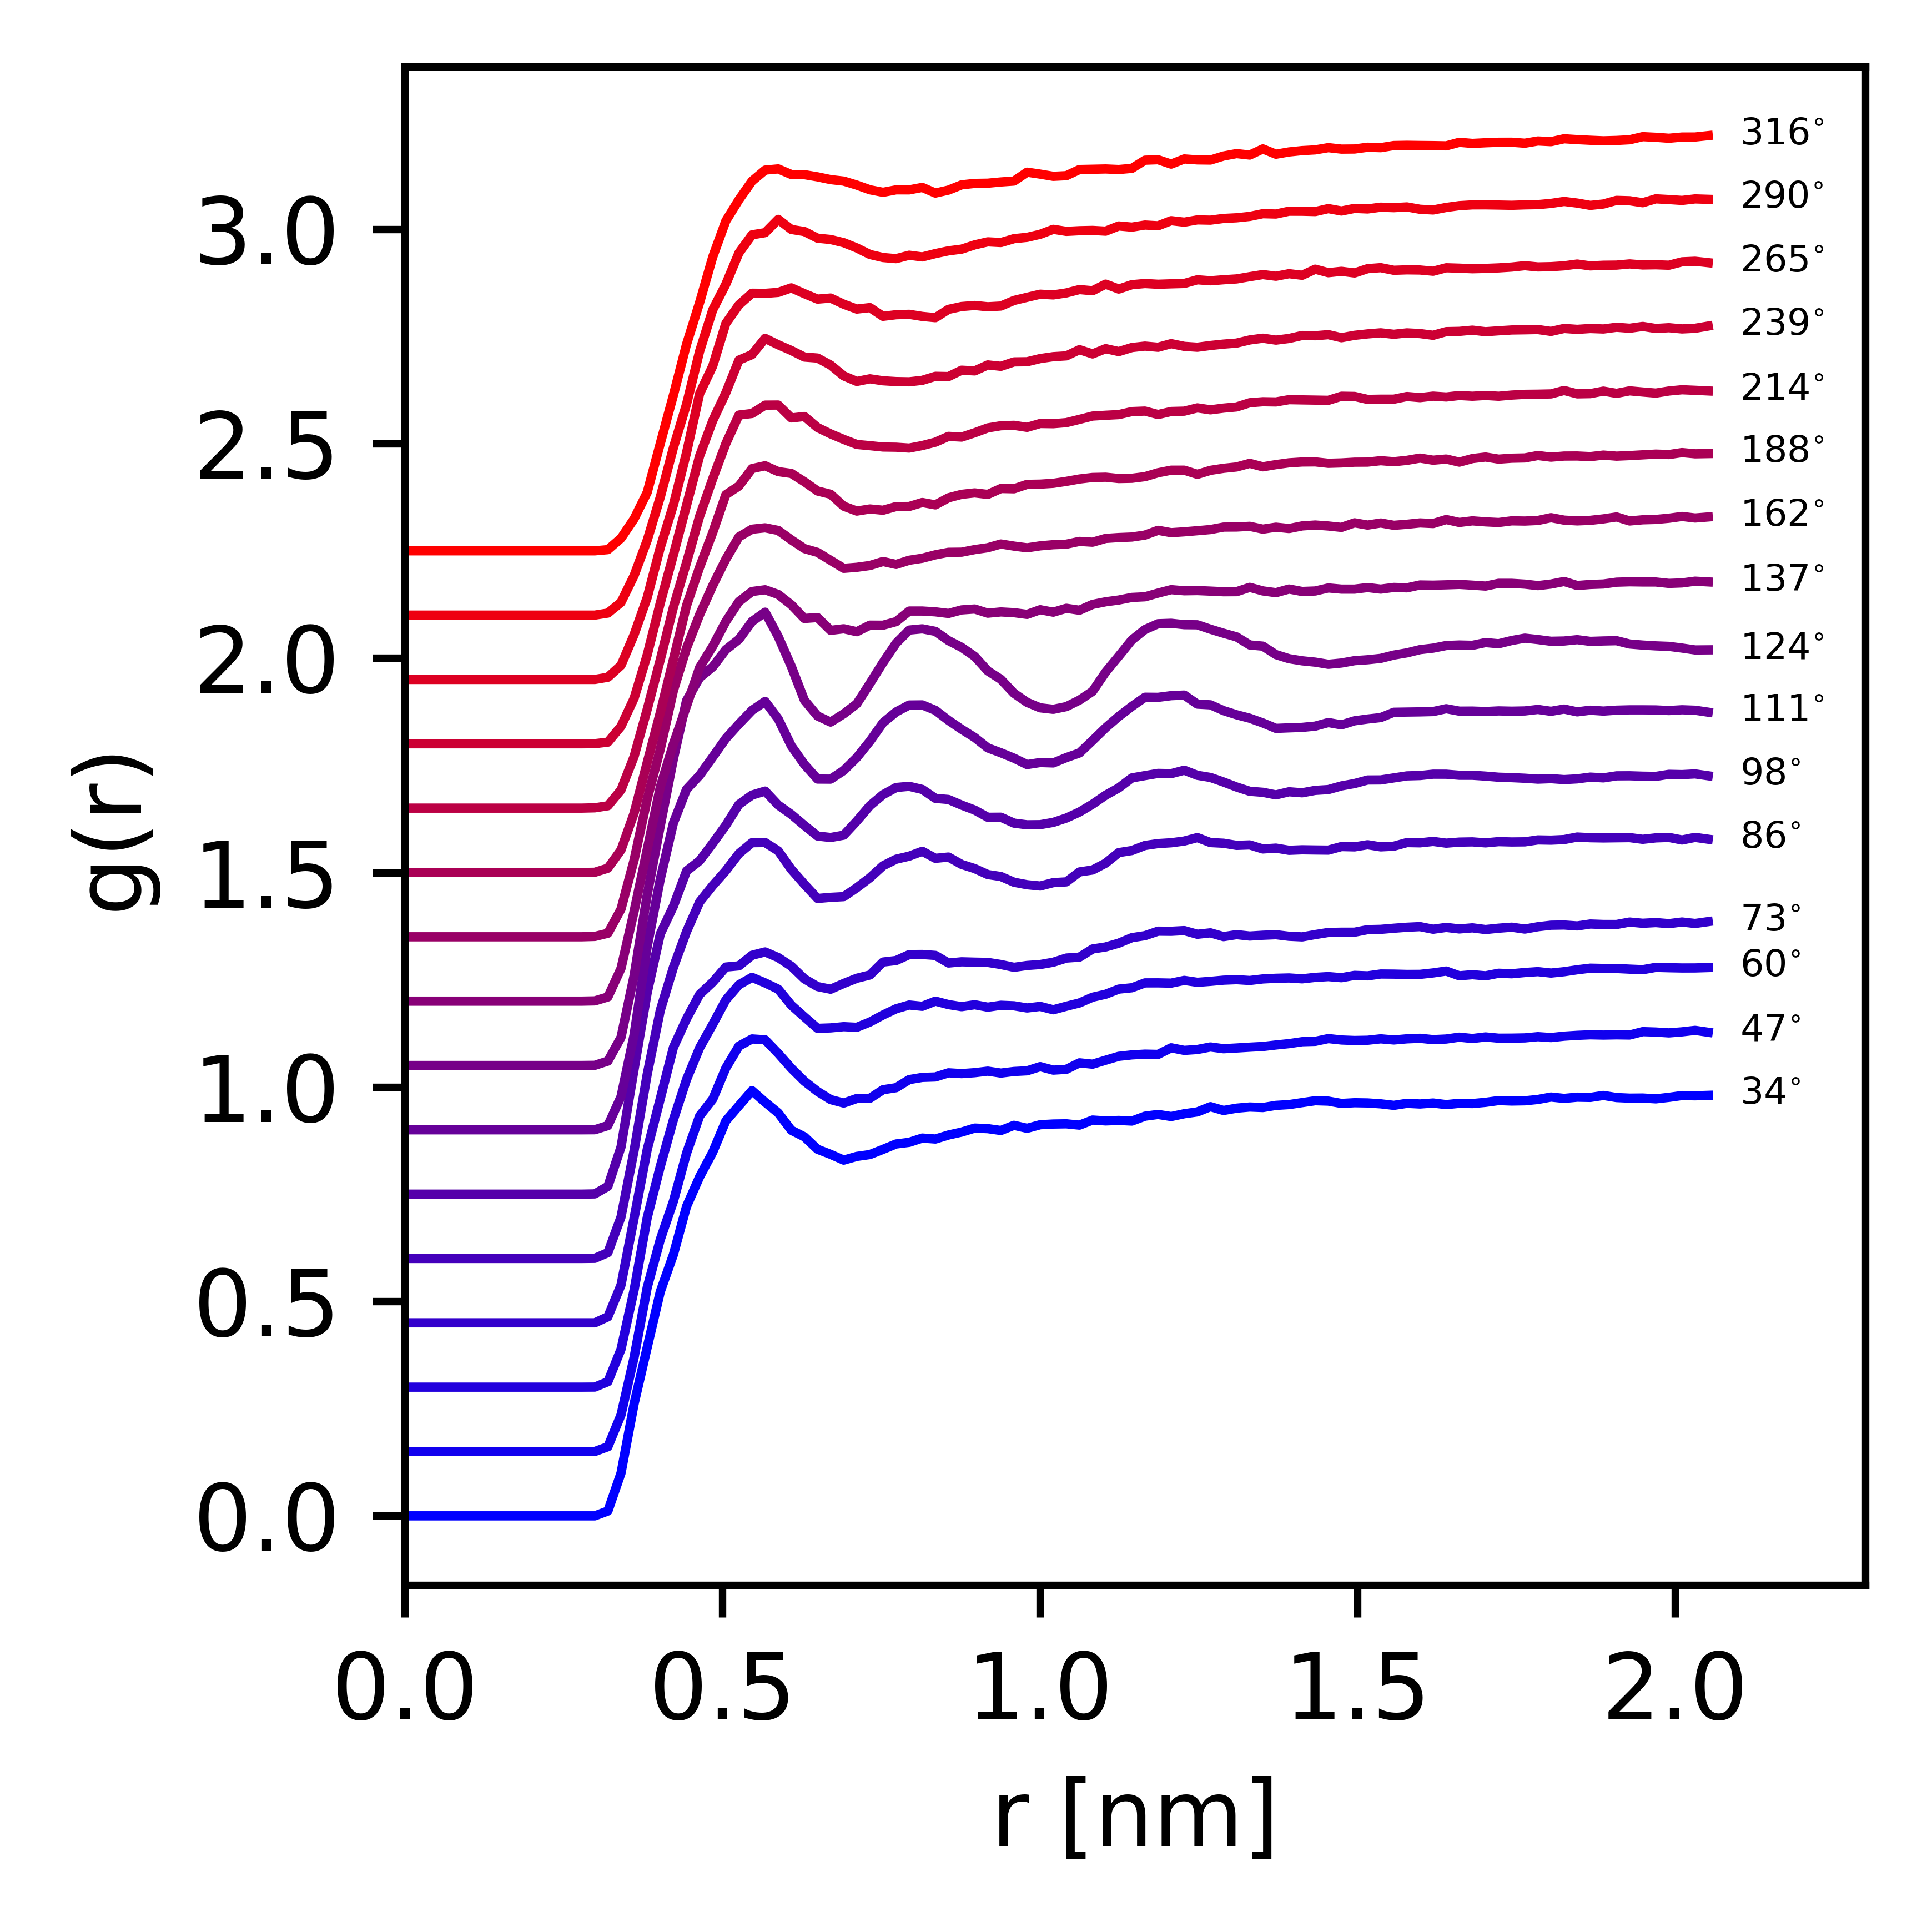

In [70]:
count = 0
colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=16)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

fig, ax = plt.subplots()

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        print()
        if not job.isfile("cg_rdf.txt"):
            continue
        if job.sp.kT < 2.4: continue
        print(np.round(kT_to_T(job.sp.kT, epsilon=1065), 0))
        print(job.path)
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        ax.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.15,
            #label=np.round(kT_to_T(job.sp.kT, epsilon=1065), 0),
            c=colors[count]
        )
        temp_label = str(int(np.round(kT_to_T(job.sp.kT, epsilon=1065), 0)))
        temp_unit = "$^{\circ}$"
        ax.text(
            data[:,0][-1]* job.doc.ref_length + 0.05,
            data[:,1][-1] + count * 0.15 - 0.02,
            temp_label + temp_unit,
            fontsize=4
        )
        count += 1

##########
# Create color map legend
#cmap = mcolors.ListedColormap(colors)
#norm = mcolors.Normalize(vmin=34, vmax=316)
#sm = ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
#cbar.set_label('Temperature $^{\circ}C$')
#cbar.set_ticks([34, 85, 110, 135, 316])
#cbar.set_ticklabels(["", "$T_g$", "$T_c$", "$T_c$", ""])
######

#plt.vlines(x=0.561, ymin=0, ymax=2, linestyles="--", colors="k", label="0.561 nm")
#plt.vlines(x=0.516, ymin=0, ymax=1.0, linestyles="--", colors="r")
#plt.vlines(x=0.867, ymin=0, ymax=2, linestyles="--", colors="green", label="0.867 nm")
#plt.vlines(x=0.82, ymin=0, ymax=1.12, linestyles="--", colors="red")
#plt.legend()
plt.ylabel("g(r)")
plt.xlabel("r [nm]")
plt.xlim(0, 2.3)
plt.tight_layout()
plt.savefig("../FIGS/rdf-all-temps-shifted-labelled.png")

In [ ]:
# Plot all temps with no shifting, add color bar legend

<>:38: DeprecationWarning: invalid escape sequence '\c'
<>:40: DeprecationWarning: invalid escape sequence '\c'
<>:40: DeprecationWarning: invalid escape sequence '\c'
<>:38: DeprecationWarning: invalid escape sequence '\c'
<>:40: DeprecationWarning: invalid escape sequence '\c'
<>:40: DeprecationWarning: invalid escape sequence '\c'
/tmp/ipykernel_13129/3188730241.py:38: DeprecationWarning: invalid escape sequence '\c'
  cbar.set_label('Temperature $^{\circ}C$')
/tmp/ipykernel_13129/3188730241.py:40: DeprecationWarning: invalid escape sequence '\c'
  cbar.set_ticklabels(["$35^{\circ}C$", "$T_g$", "$T_c$", "$T_c$", "$316 ^{\circ}C$"])
/tmp/ipykernel_13129/3188730241.py:40: DeprecationWarning: invalid escape sequence '\c'
  cbar.set_ticklabels(["$35^{\circ}C$", "$T_g$", "$T_c$", "$T_c$", "$316 ^{\circ}C$"])










34.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9142f5e776ff060fb7edb01495a9a86e

47.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/1cbc57c38be8cfe0ae9994bcb19467e2

60.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/a5250cea52a262d308592249ce463d10

73.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/393a1cc581d5324e470714d7c681dcac

86.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/51e475756aeadda668351a024760dcda

98.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/9a2350bfd349debae443b6dd5f1beb2f

111.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/73e2a18dd6e440ba0066c934fcb829e0

124.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678

137.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/d4f337da0a7ee79a1778c858471aa917

162.0
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/39edcdb395b6

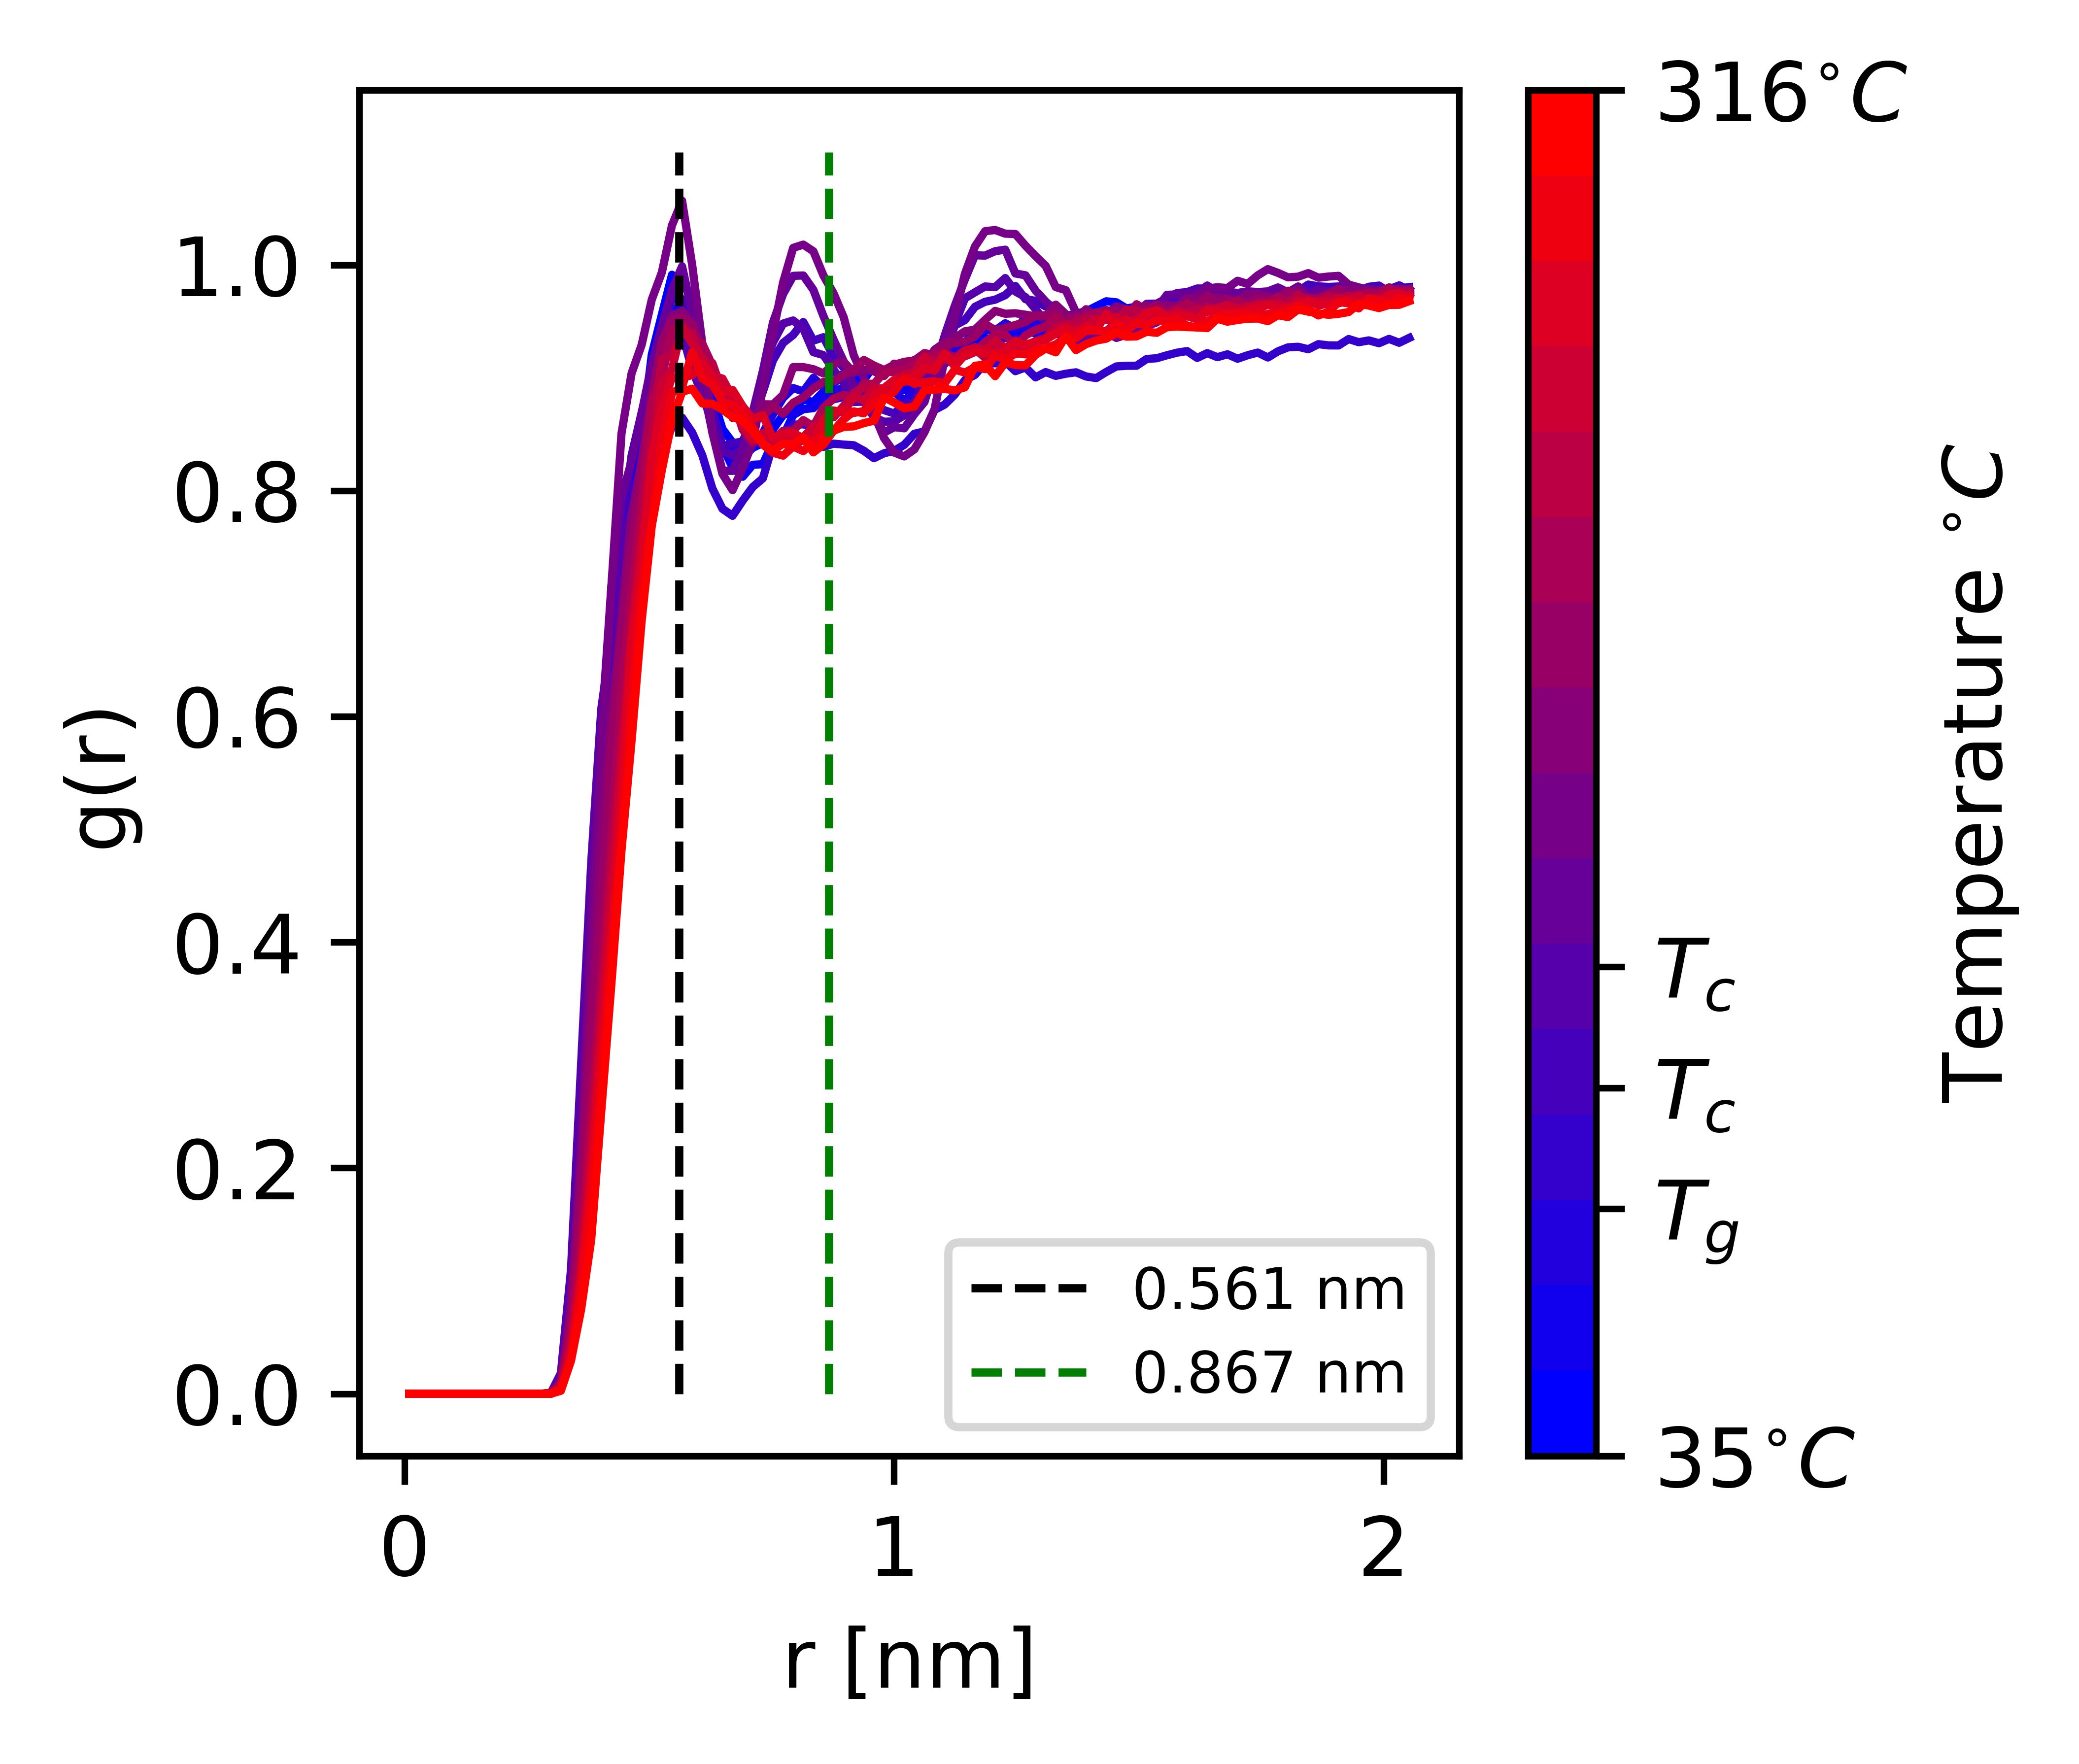

In [68]:
count = 0
shift_by = 0
colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=16)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

fig, ax = plt.subplots()

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        print()
        if not job.isfile("cg_rdf.txt"):
            continue
        if job.sp.kT < 2.4: continue
        print(np.round(kT_to_T(job.sp.kT, epsilon=1065), 0))
        print(job.path)
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        ax.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * shift_by,
            #label=np.round(kT_to_T(job.sp.kT, epsilon=1065), 0),
            c=colors[count]
        )
        count += 1

##########
# Create color map legend
cmap = mcolors.ListedColormap(colors)
norm = mcolors.Normalize(vmin=34, vmax=316)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Temperature $^{\circ}C$')
cbar.set_ticks([34, 85, 110, 135, 316])
cbar.set_ticklabels(["$35^{\circ}C$", "$T_g$", "$T_c$", "$T_c$", "$316 ^{\circ}C$"])
######

plt.vlines(x=0.561, ymin=0, ymax=1.1, linestyles="--", colors="k", label="0.561 nm")
#plt.vlines(x=0.516, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.vlines(x=0.867, ymin=0, ymax=1.1, linestyles="--", colors="green", label="0.867 nm")
#plt.vlines(x=0.82, ymin=0, ymax=1.12, linestyles="--", colors="red")
plt.legend()
plt.ylabel("g(r)")
plt.xlabel("r [nm]")
#plt.tight_layout()
plt.savefig("../FIGS/rdf-all-temps.png")
















124.0 3.1
/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/100888a4bbe8114d13b7c682ba77a678










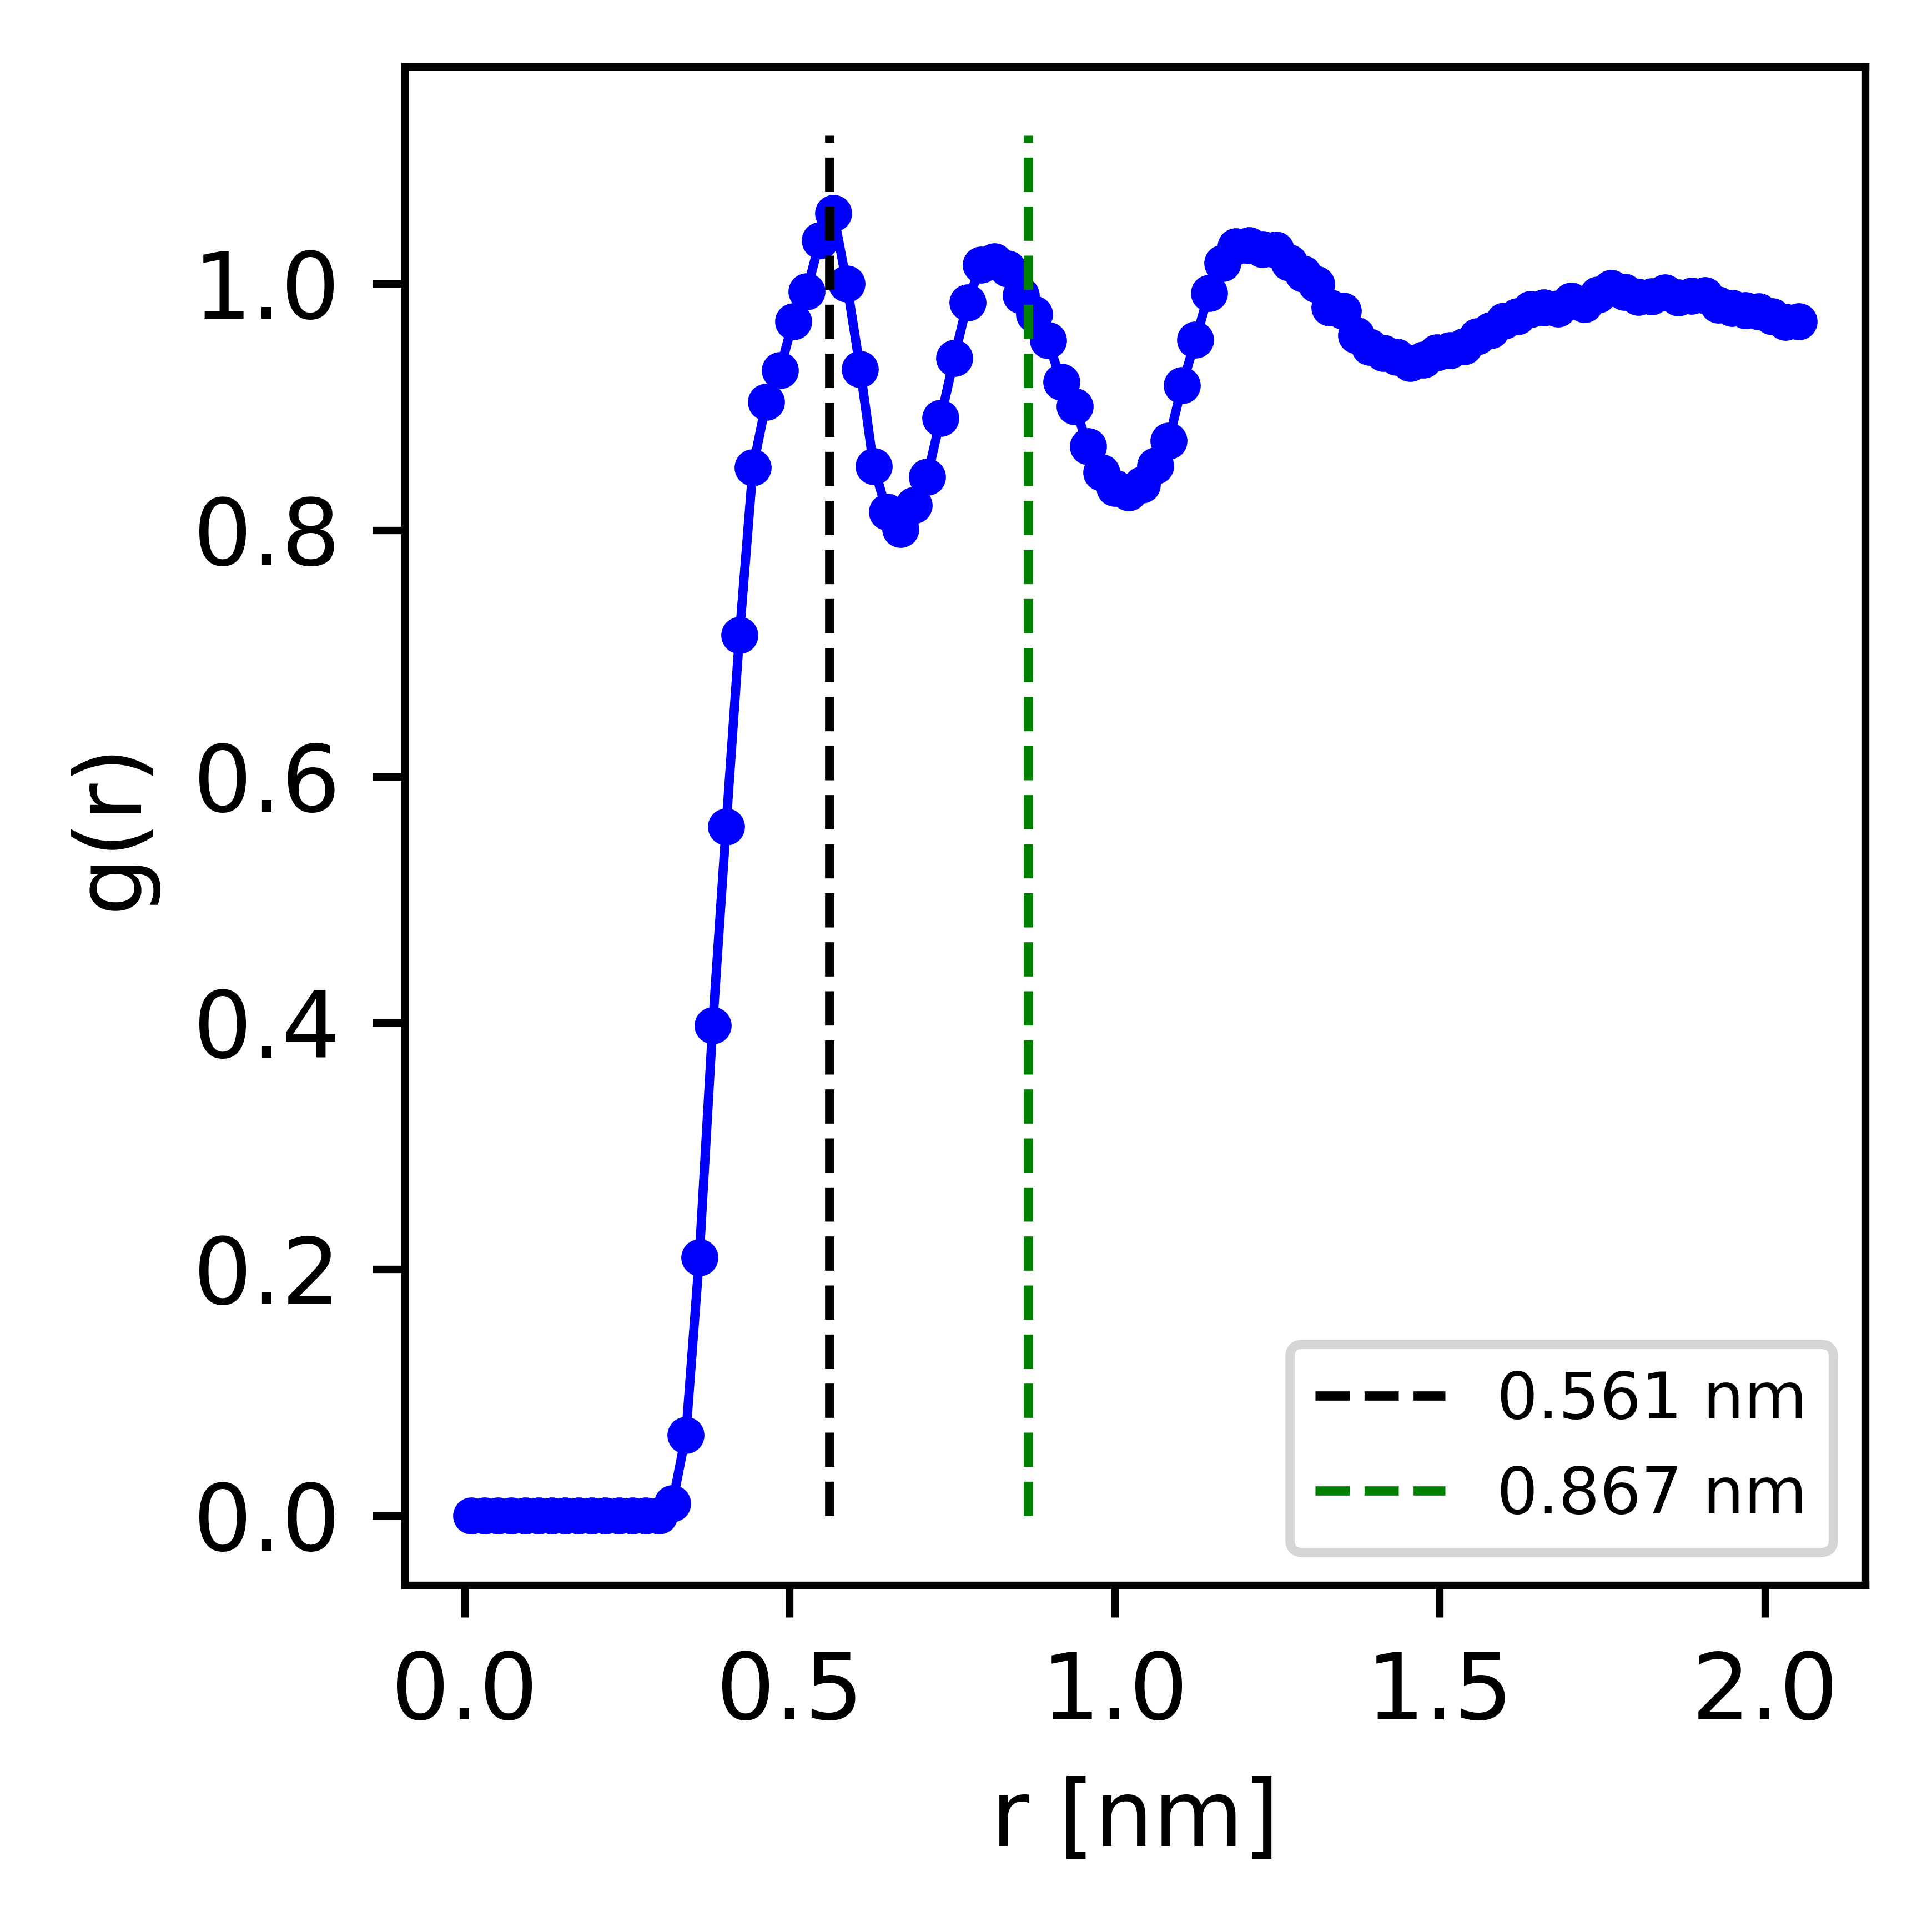

In [12]:
count = 0
colors = generate_color_gradient(start_color="blue", end_color="red", num_steps=16)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    for job in jobs:
        print()
        if not job.isfile("cg_rdf.txt"):
            continue
        T_real = np.round(kT_to_T(job.sp.kT, epsilon=1065), 0)
        if T_real != 124.0:
            continue
        print(T_real, job.sp.kT)
        print(job.path)
        data = np.loadtxt(job.fn("cg_rdf.txt"))
        plt.plot(
            data[:,0] * job.doc.ref_length, data[:,1] + count * 0.00, marker="o",
            #label=np.round(kT_to_T(job.sp.kT, epsilon=1065), 0),
            c=colors[count]
        )
        count += 1

plt.vlines(x=0.561, ymin=0, ymax=1.12, linestyles="--", colors="k", label="0.561 nm")
#plt.vlines(x=0.516, ymin=0, ymax=1.0, linestyles="--", colors="r")
plt.vlines(x=0.867, ymin=0, ymax=1.12, linestyles="--", colors="green", label="0.867 nm")
#plt.vlines(x=0.82, ymin=0, ymax=1.12, linestyles="--", colors="red")
plt.legend()
plt.ylabel("g(r)")
plt.xlabel("r [nm]")
plt.tight_layout()
plt.savefig(f"../FIGS/rdf-highest-order_124C_{job.sp.kT}kT.png")

# Structure Factors:

In [25]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    #"kT": 3.0,
    #"doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}

count = 0
job_id = "73e2a18dd6e440ba0066c934fcb829e0"
for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    if kT < 2.4: continue
    for job in jobs:
        if job_id:
            if job.id != job_id:
                continue
        #if job.isfile("cg_sf.txt"):
        #    continue
        fpath = job.fn("target_1monomer_per_bead.gsd")
        fpath = job.fn("trajectory-nvt0.gsd")
        sf = structure_factor(
            gsdfile=fpath,
            k_min=0.01,
            k_max=12,
            start=-10,
            stop=-1,
            ref_length=job.doc.ref_length,
            bins=50
        )
        x = sf.bin_centers
        y = sf.S_k
        save_data = np.vstack([x, y]).T
        np.savetxt(job.fn("cg_sf.txt"), save_data)
        #plt.plot(x, y+(count*0.25), label=kT, c=colors[count])
        count += 1

#plt.legend(loc="right")

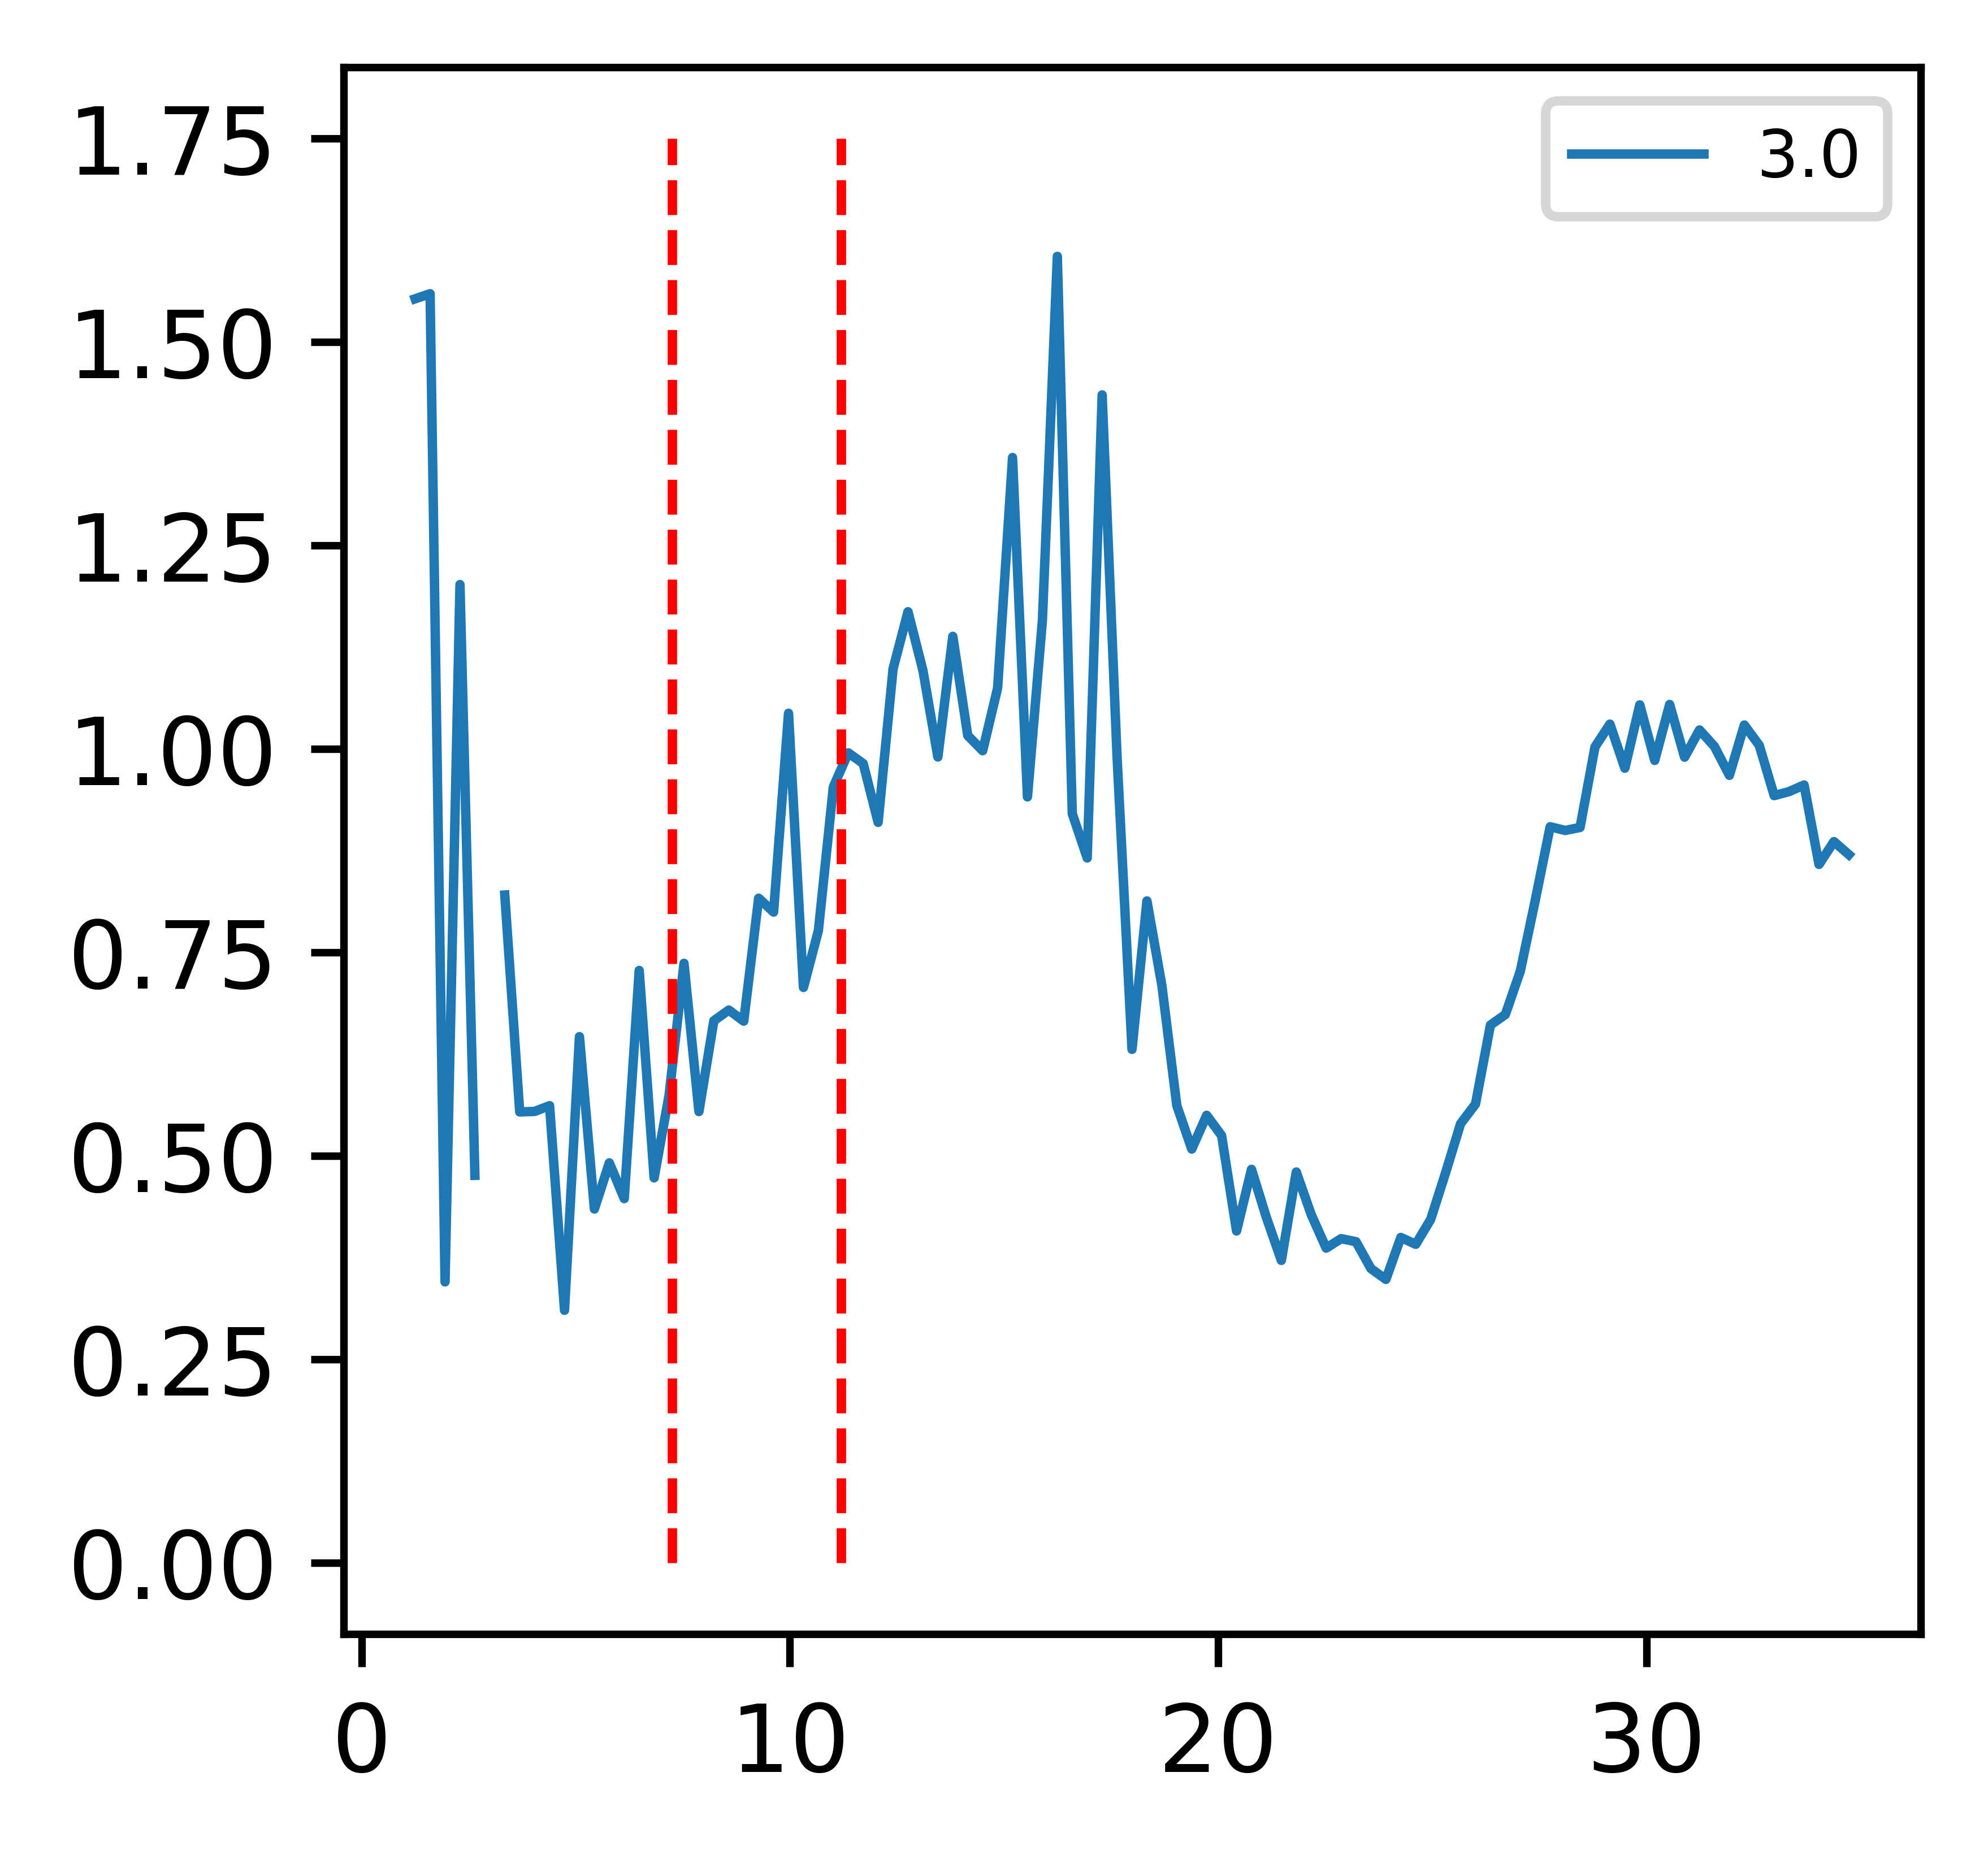

In [24]:
count = 0
fig = plt.figure()

for kT, jobs in project.find_jobs(job_filter).groupby("kT"):
    if kT < 2.4: continue
    for job in jobs:
        if job_id:
            if job.id != job_id:
                continue
        data = np.loadtxt(job.fn("cg_sf.txt"))
        wave_vectors = data[:,0]
        thetas = k_vector_to_2theta(wave_vectors, wave_length=0.15406)
        distances = k_vector_to_distance(wave_vectors)
        #plt.plot(data[:,0], data[:,1], label=kT)
        #plt.plot(thetas, data[:,1], label=kT)
        plt.plot(wave_vectors, data[:,1], label=kT)

plt.vlines(ymin=0, ymax=1.75, x=2*np.pi/0.561, linestyle="--", color="red")
plt.vlines(ymin=0, ymax=1.75, x=2*np.pi/0.867, linestyle="--", color="red")

plt.legend()
#plt.xlim(0, 1.2)

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        fig = plt.figure()
        fpath = job.fn(f"cg-npt.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=20, start=-10, stop=-1, ref_length=None)
        x = sf.bin_centers
        y = sf.S_k
        plt.plot(x, y, label=kT, c=colors[count])
        plt.title(f"kT: {kT}")
        plt.show()
        print()

In [ ]:
for kT, jobs in project.find_jobs({"sigma_scale": 0.955}).groupby("kT"):
    if kT < 2.0: continue
    for job in jobs:
        print(kT, job.path)

In [ ]:
for kT, jobs in project.find_jobs(
    {"doc.nvt_equilibrated": True,
     "sigma_scale": 0.955,
     "kT": 2.4,
     }).groupby("kT"):
    for job in jobs:
        #if not job.isfile("ua_structure_factor.txt"):
        fpath = job.fn(f"trajectory-nvt{job.doc.nvt_runs-1}.gsd")
        sf = structure_factor(gsdfile=fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = sf.bin_centers
        y = sf.S_k
        save_data = np.vstack([sf.bin_centers, sf.S_k]).T
        np.savetxt(job.fn("ua_structure_factor.txt"), save_data)
        #if not job.isfile("cg_structure_factor.txt"):
        cg_fpath = job.fn("cg-nvt.gsd")
        cg_sf = structure_factor(gsdfile=cg_fpath, k_min=0.5, k_max=30, start=-50, stop=-1, ref_distance=None)
        x = cg_sf.bin_centers
        y = cg_sf.S_k
        save_data = np.vstack([cg_sf.bin_centers, cg_sf.S_k]).T
        np.savetxt(job.fn("cg_structure_factor.txt"), save_data)
        #job.doc.sf_sampled = True

In [ ]:
plt.plot(sf.bin_centers, sf.S_k, label=kT)

In [ ]:
for kT, jobs in project.find_jobs({"doc.nvt_equilibrated": True, "sigma_scale": 0.955}).groupby("kT"):
    for job in jobs:
        fig = plt.figure()
        sf = np.loadtxt(job.fn("ua_structure_factor.txt"))
        plt.plot(sf[:,0], sf[:,1], label=kT)
        plt.legend()
        plt.show()

#plt.legend()
#plt.ylim(0, 4)
#plt.show()

# Diffraction Patterns:

In [ ]:
job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.0,
    "doc.npt_equilibrated": False,
    "sigma_scale": 0.955
}
for job in project.find_jobs(filter=job_filter):
    print(job)

In [29]:
views = get_quaternions(n_views=12)

In [48]:
views = get_quaternions(n_views=30)

job_filter = {
    "remove_hydrogens": True,
    "remove_charges": False,
    "kT": 3.6,
    "doc.npt_equilibrated": True,
    "sigma_scale": 0.955
}

for job in project.find_jobs(filter=job_filter):
    print(job.path)
    dp = diffraction_pattern(
        gsdfile=job.fn("target_1monomer_per_bead.gsd"),
        ref_length=job.doc.ref_length,
        views=views,
        grid_size=512,
        start=-10,
        stop=-1,
    )

/home/erjank_project/PPS-MSIBI/pps-msibi/validation/workspace/ddff72030898e479189cd2df660938e3


<Axes: title={'center': 'Diffraction Pattern'}, xlabel='$k_x$', ylabel='$k_y$'>

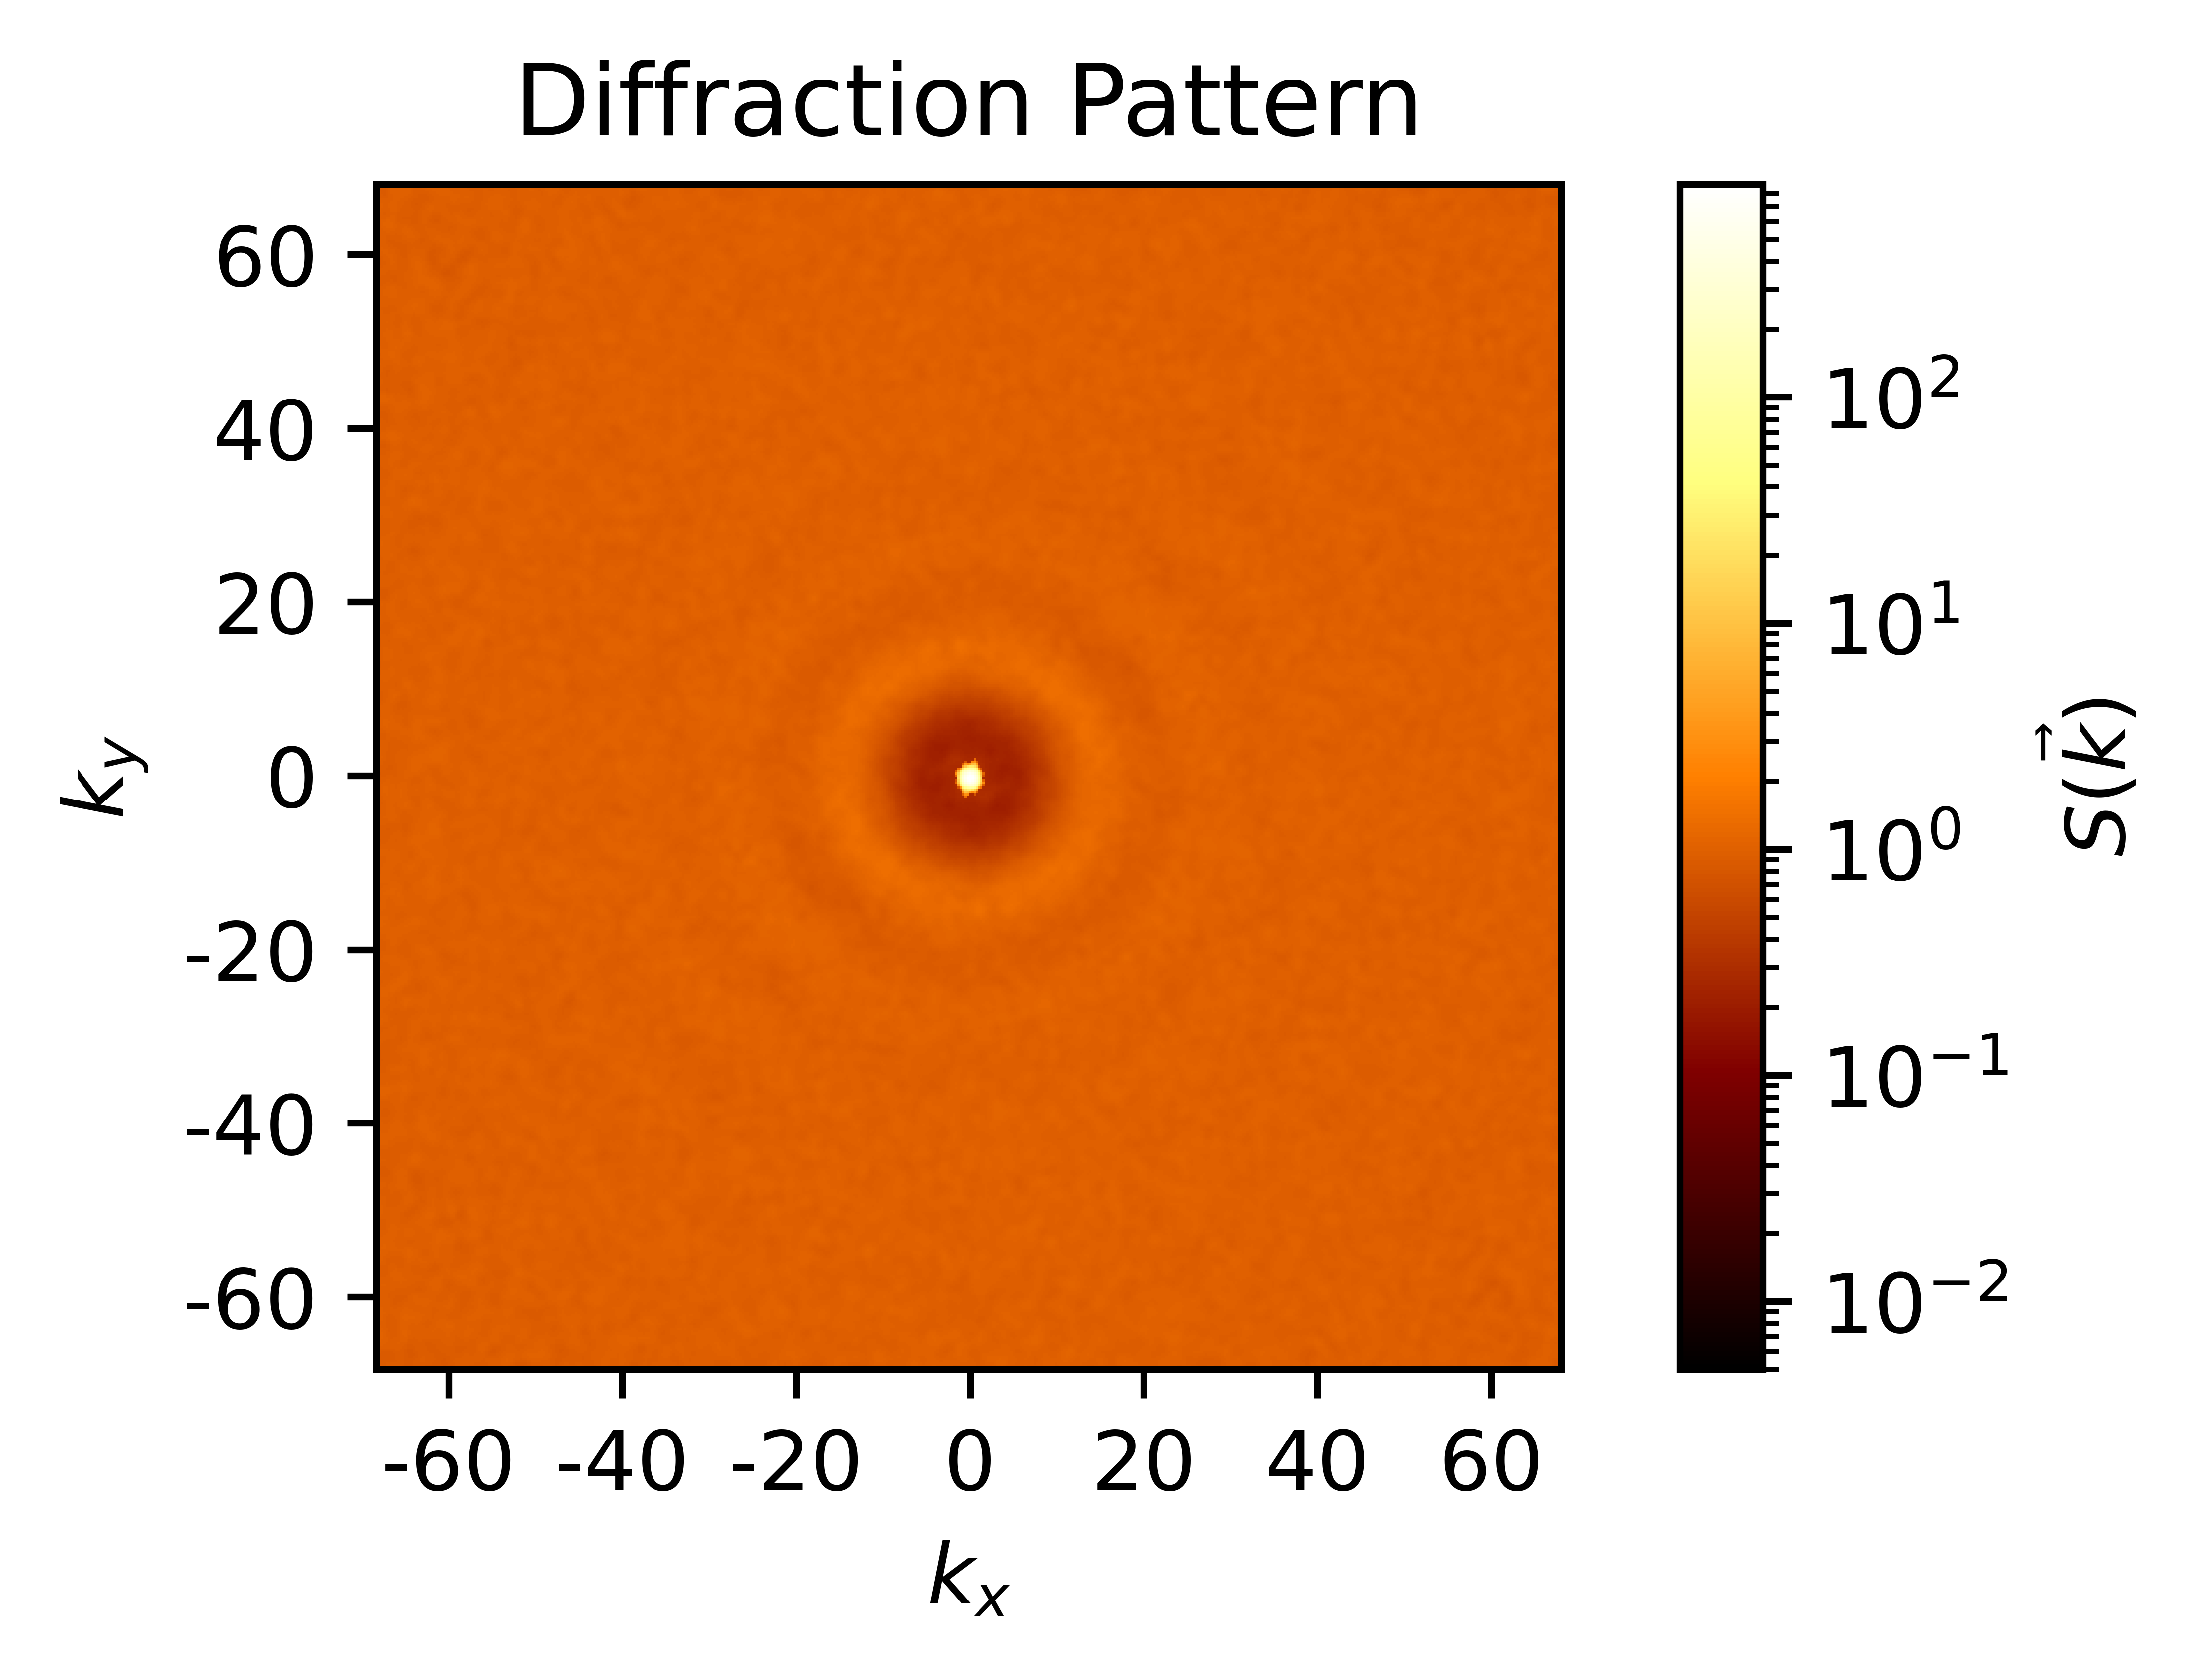

In [49]:
dp.plot()

In [ ]:
views = get_quaternions(n_views=4)

In [ ]:
run = 25

pic_count = 0

for i in range(1, 26):
    gsdfile = job.fn(f"trajectory-npt{i}.gsd")
    with gsd.hoomd.open(gsdfile) as traj:
        num_frames = len(traj)
        print(i, num_frames)
    for j in range(10, num_frames-10, 10):
        dp = diffraction_pattern(
            gsdfile=job.fn(f"trajectory-npt{i}.gsd"),
            views=[views[1]],
            start=j-10,
            stop=j
        )
        dp.plot().figure.savefig(f"images/dp{pic_count}.png")
        pic_count += 1

In [ ]:
dp.plot().figure.savefig("test.png")

In [ ]:
job.doc.npt_runs

In [ ]:
movie_maker(file_dir="images/", img_file_type="png", mov_file_name="pps_diff.mp4", framerate=80)